In [1]:
!pip install -q transformers datasets evaluate


In [2]:
!pip install --upgrade transformers



In [1]:
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
from structures.dataset_structure import COCOSegmentationDataset
from utils.data_preprocessor_utils import *
from utils.visualize_utils import *

In [3]:
datadir = "./data/car-parts-and-car-damages/"
carparts_dir = os.path.join(datadir,"Car_parts_dataset")
cardamages_dir = os.path.join(datadir,"Car_damages_dataset")
carparts_imgs = os.path.join(carparts_dir,"split_dataset")
carparts_anns = os.path.join(carparts_dir,"split_annotations")
cardamages_imgs = os.path.join(cardamages_dir,"split_dataset")
cardamages_anns = os.path.join(cardamages_dir,"split_annotations")

In [4]:
cardamage_id_to_color = get_colormapping(cardamages_dir+"/coco_damage_annotations.json",cardamages_dir+"/meta.json")
carpart_id_to_color = get_colormapping(carparts_dir+"/coco_parts_annotations.json",carparts_dir+"/meta.json")
cardamage_id_to_color,carpart_id_to_color,len(carpart_id_to_color)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


({3: '#13A4C9',
  2: '#A6FF47',
  6: '#B42D38',
  8: '#E19660',
  1: '#903C59',
  7: '#A7741B',
  4: '#B40E13',
  5: '#73C2CE'},
 {16: '#5C7529',
  2: '#40993D',
  12: '#913021',
  20: '#E5F83A',
  8: '#FE2FC0',
  15: '#C19744',
  3: '#E62D30',
  7: '#E95353',
  9: '#903765',
  13: '#9A87CF',
  4: '#320698',
  14: '#8206DB',
  21: '#963C3D',
  1: '#4355CB',
  6: '#D50BB4',
  18: '#2E7F62',
  17: '#90D092',
  5: '#4AF778',
  19: '#7C93DA',
  10: '#BC574E',
  11: '#87DB00'},
 21)

In [ ]:
# Create dataset
train_cardamage_dataset = get_dataset(cardamages_imgs,cardamages_anns,is_train=True)
val_cardamage_dataset = get_dataset(cardamages_imgs,cardamages_anns)


root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/train.json
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/val
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/val.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
# Check an example
image, mask = train_cardamage_dataset[4]
print(image.shape, mask.shape)  # Tensor dimensions

torch.Size([3, 594, 800]) torch.Size([1, 594, 800])


In [7]:
# with open('./mask.txt', 'w') as f:
#     for m in mask.numpy()[0]:
#         f.write("%s\n" % m)

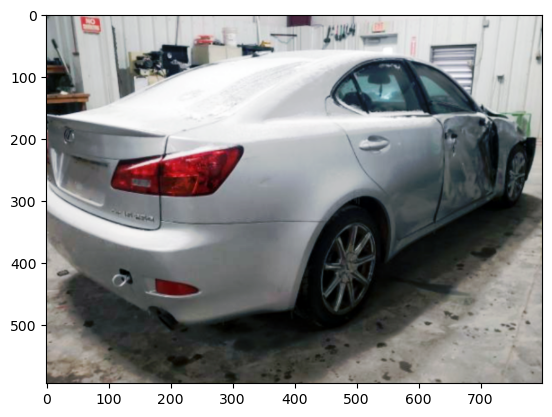

In [8]:
plt.imshow(unnormalize_image(image.transpose(0,-1).transpose(0,1).numpy()))

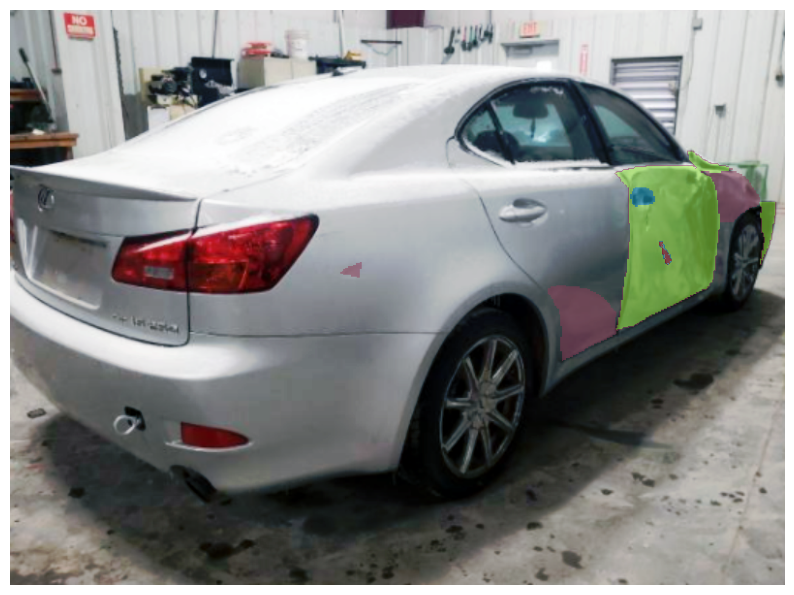

In [9]:
overlayed_image = overlay_colored_mask(image.transpose(0,-1).transpose(0,1).numpy(), mask[0].numpy(), cardamage_id_to_color, alpha=0.5)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [10]:
from torch.utils.data import DataLoader

# Create DataLoader
tr_cd_dataloader = DataLoader(train_cardamage_dataset, batch_size=4, shuffle=True)
val_cd_dataloader = DataLoader(val_cardamage_dataset, batch_size=4)

In [11]:
im,ms = next(iter(tr_cd_dataloader))
im.size(),ms.size()

(torch.Size([4, 3, 594, 800]), torch.Size([4, 1, 594, 800]))

: 

In [18]:
%env CUDA_VISIBLE_DEVICES
%env CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7
%env CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7


'0,1,2,3,4,5,6,7'

In [26]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

# Modify the classifier layer to match the number of classes in your dataset
# Assuming the model's `decode_head` has a classifier head for segmentation.
model.decode_head.classifier = torch.nn.Conv2d(768, len(cardamage_id_to_color), kernel_size=1)

In [ ]:
from transformers import AdamW, get_scheduler
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)  # Set the learning rate

# Define the number of epochs
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the learning rate scheduler
num_training_steps = num_epochs * len(tr_cd_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(tr_cd_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        images, masks = batch
        images = images.to(device)
        masks = masks.squeeze(1).to(device)
        # print(images.size(),masks.size())
        # Forward pass
        outputs = model(images, labels=masks)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({"loss": loss.item()})

    # Evaluation after each epoch
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_cd_dataloader:
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images, labels=masks)
            loss = outputs.loss
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_cd_dataloader)
    print(f"Validation loss after epoch {epoch+1}: {avg_val_loss}")


2024-12-30 01:22:32.797693: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797803: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/

inputs  torch.Size([1, 3, 1024, 1024])
logits  torch.Size([1, 19, 256, 256])


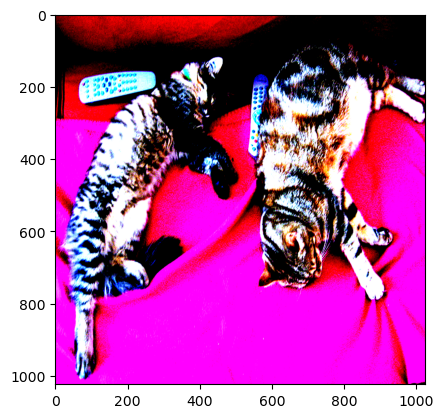

In [18]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = feature_extractor(images=image, return_tensors="pt")
print("inputs ",inputs["pixel_values"].shape)
plt.imshow(inputs["pixel_values"][0].transpose(0,-1).transpose(0,1).numpy())
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
print("logits ",logits.size())

In [19]:
from transformers import TrainingArguments

epochs = 5
lr = 2e-4
batch_size = 8

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-2"

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    logging_dir='./logs',
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # The model to train
    args=training_args,                 # Training arguments
    train_dataset=train_dataset,        # Training dataset
    eval_dataset=val_dataset,           # Validation dataset
    tokenizer=feature_extractor,       # Feature extractor for preprocessing
)

# Start training
trainer.train()


In [ ]:
# Evaluate the model on the validation dataset
trainer.evaluate()


In [ ]:
from PIL import Image

# Load a sample image from your dataset
sample_image = Image.open("path/to/sample/image.jpg")

# Preprocess the image using the feature extractor
inputs = feature_extractor(sample_image, return_tensors="pt")

# Get the model's predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Convert logits to segmentation mask
predicted_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

# Visualize the segmentation output
plt.imshow(predicted_mask)
plt.show()


In [ ]:
# Save the model and feature extractor
model.save_pretrained("./segformer_custom_model")
feature_extractor.save_pretrained("./segformer_custom_model")
